In [128]:
!pip install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33271 sha256=ef16f7a225e7155e5272c5b91ec2057d6742f781c6d3f44730175dfd853fca3a
  Stored in directory: /root/.cache/pip/wheels/c7/61/da/39b050eea5710fe32b1521b79de4a74d95896581230d30a37b
Successfully built deep_phonemizer


In [131]:
import os
import re
import math
import torch
import IPython
import torchaudio
import pandas as pd
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

**Hyperparameters**

In [2]:
max_caption_length = 15
image_size = 224
batch_size = 16
image_embed_size = 256
text_embed_size = 256
lr = 3e-4
epochs = 25
hidden_size = 1500
num_layers = 2
num_heads = 4
dropout = 0.2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utility Functions

In [4]:
# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, losses, val_losses):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'Loss': losses,
        'val_loss': val_losses,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

In [5]:
# Function to load checkpoint
def load_checkpoint(model, optimizer):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        epoch = checkpoint['epoch']
        losses = checkpoint['Loss']
        val_losses = checkpoint['val_loss']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'Checkpoint loaded from {checkpoint_path}')
        return epoch + 1, losses, val_losses
    else:
        print(f'No checkpoint found at {checkpoint_path}. Starting from epoch 0')
        return 0, [], []

In [6]:
def clip_loss(similarity_mat, criterion):
    total_loss = 0.0

    for i in range(similarity_mat.shape[0]):
        truth = torch.zeros(similarity_mat.shape[0]).to(device)
        truth[i] = 1
        total_loss += criterion(similarity_mat[i, :], truth)

    for i in range(similarity_mat.shape[0]):
        truth = torch.zeros(similarity_mat.shape[0]).to(device)
        truth[i] = 1
        total_loss += criterion(similarity_mat[:, i], truth)

    return total_loss

In [7]:
def get_real_captions(reversed_vocab, batch_tensors):
    sentences = []
    for tensor in batch_tensors:
        words = []
        for number in tensor:
            if reversed_vocab[int(number)]!='<eos>':
                words.append(reversed_vocab[int(number)])
            else:
                break
        
        sentence = ' '.join(filter(None, words[1:]))  
        sentences.append(sentence)

    return sentences

In [37]:
def display_image_with_captions(image, real_caption, generated_caption):
    image = image.cpu().squeeze(0)
    image = transforms.ToPILImage()(image)

    plt.imshow(image)
    plt.axis('off')

    # Add real and generated captions below the image
    plt.text(0, image.size[1], "Real Caption: " + real_caption, fontsize=12, wrap=True, verticalalignment='top')
    plt.text(0, image.size[1] + 20, "Generated Caption: " + generated_caption, fontsize=12, wrap=True,
             verticalalignment='top')

    plt.show()

In [129]:
def text2speech(input_text):
    bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

    processor = bundle.get_text_processor()
    tacotron2 = bundle.get_tacotron2().to(device)
    vocoder = bundle.get_vocoder().to(device)
    with torch.inference_mode():
        processed, lengths = processor(input_text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        waveforms, lengths = vocoder(spec, spec_lengths)

    return IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

# Dataset and DataLoaders

In [8]:
def lower_case(text):
    l = []
    for i in text.split():
        l.append(i.lower())

    return " ".join(l)


def remove_numbers_punctuation_special(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text


class ImagesToCaptionDataset(Dataset):
    def __init__(self, caption_path, images_path, max_caption_length, frequency_threshold, transform=None):
        super().__init__()
        self.frequency_threshold = frequency_threshold
        self.images_path = images_path
        self.data = pd.read_csv(caption_path)
        self.images = self.data['image']
        self.captions = self.data['caption']
        self.captions = self.captions.apply(lower_case)
        self.captions = self.captions.apply(remove_numbers_punctuation_special)
        self.transform = transform
        self.max_length = max_caption_length - 2
        self.vocabulary = self.get_vocabulary()
        self.vocab_size = len(self.vocabulary)

    def get_vocabulary(self):
        vocab = {'<sos>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3}
        frequency = {}
        idx = 4
        for i in self.captions:
            for j in i.split():
                if j not in frequency:
                    frequency[j] = 1
                else:
                    frequency[j] += 1

                if frequency[j] == self.frequency_threshold:
                    vocab[j] = idx
                    idx += 1
        return vocab

    def prepare_sequence(self, seq):
        idxs = [0]
        idxs += [self.vocabulary[w] if w in self.vocabulary else self.vocabulary['<unk>'] for w in seq]
        idxs += [2]

        if len(idxs) < self.max_length + 2:
            idxs += [1] * (self.max_length + 2 - len(idxs))

        else:
            idxs = idxs[:self.max_length + 2]

        return idxs

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image = Image.open(os.path.join(self.images_path, image_name)).convert('RGB')
        caption = self.captions[index]
        caption = self.prepare_sequence(caption.split())

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption, dtype=torch.long)


transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = ImagesToCaptionDataset('/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt', '/kaggle/input/flickr8kimagescaptions/flickr8k/images', max_caption_length,5,transform)
vocabulary_size = dataset.vocab_size
caption_vocab = dataset.vocabulary

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)


In [9]:
reversed_vocab = {value: key for key, value in caption_vocab.items()}

# Models

In [10]:
class ImageEmbedding(nn.Module):
    def __init__(self, max_caption_length, hidden_size, embedding_size):
        super().__init__()
        self.max_caption_length = max_caption_length
        model = models.resnet152(weights = 'ResNet152_Weights.IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, hidden_size)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
        self.model = model
        self.linear = nn.Linear(100, embedding_size)

    def forward(self, x):
        x = self.model(x)
        x = x.reshape(x.shape[0], self.max_caption_length, -1)
        return self.linear(x)


class TextEmbedding(nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, num_layers, num_heads, dropout):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(embedding_size, num_heads, hidden_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embeddings = self.embeddings(x)
        embeddings = self.positional_encoding(embeddings)
        embeddings = self.dropout(embeddings)
        embeddings = embeddings.permute(1, 0, 2)  
        output = self.transformer_encoder(embeddings)
        output = output.permute(1, 0, 2)  
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2) * -(math.log(10000.0) / embedding_size))
        pe = torch.zeros(max_len, 1, embedding_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class ProposedModel(nn.Module):
    def __init__(self, image_embed_size, text_embed_size, vocab_size, hidden_size, num_layers, num_heads, dropout, caption_length):
        super().__init__()
        self.image_embeddings = ImageEmbedding(caption_length, hidden_size, image_embed_size)
        self.text_embeddings = TextEmbedding(text_embed_size, vocab_size, hidden_size, num_layers, num_heads, dropout)

    def forward(self, image, captions):
        image_embeddings = self.image_embeddings(image)
        text_embeddings = self.text_embeddings(captions)
        
        # Flatten the embeddings
        x1_flat = image_embeddings.reshape(image_embeddings.size(0), -1)
        x2_flat = text_embeddings.reshape(text_embeddings.size(0), -1)

        # Normalize the embeddings
        x1_norm = torch.nn.functional.normalize(x1_flat, p=2, dim=1)
        x2_norm = torch.nn.functional.normalize(x2_flat, p=2, dim=1)

        # Calculate cosine similarity
        similarity_matrix = torch.matmul(x1_norm, x2_norm.T)
        return similarity_matrix

In [11]:
model = ProposedModel(image_embed_size, text_embed_size, vocabulary_size, hidden_size, num_layers, num_heads, dropout, max_caption_length).to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 165MB/s]  
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training Model

In [12]:
checkpoint_dir = '/kaggle/working/clip_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [13]:
# Optimizers
optimizer = optim.Adam(model.parameters(), lr)

# Loss Functions
criterion = nn.CrossEntropyLoss()

In [14]:
start_epoch, losses, val_losses = load_checkpoint(model, optimizer)

# Loop over epochs
for epoch in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0

    print()
    for org_image, org_caption in train_loader:
        org_image = org_image.to(device)
        org_caption = org_caption.to(device)

        optimizer.zero_grad()
        similarity_mat = model(org_image, org_caption)

        loss = clip_loss(similarity_mat, criterion)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Append epoch losses to the lists for plotting
    losses.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for org_image, org_caption in val_loader:
            org_image = org_image.to(device)
            org_caption = org_caption.to(device)

            outputs = model(org_image, org_caption)
            loss = clip_loss(outputs, criterion)
            total_val_loss += loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    print(
        f'Epoch [{epoch + 1}/{epochs}] | Training Loss = {total_loss / len(train_loader):.4f} | Validation Loss = {total_val_loss / len(val_loader):.4f}')

    # Save checkpoint after each epoch
    if val_losses[-1] <= min(val_losses):
        save_checkpoint(epoch, model, optimizer, losses, val_losses)
    # Plot encoder loss
    plt.plot(range(1, epoch + 2), losses, label='Training Loss', color='blue')
    plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Captioner Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('/kaggle/working/loss_clip.png')
    plt.close()

No checkpoint found at /kaggle/working/clip_checkpoints/checkpoint_epoch.pt. Starting from epoch 0

Epoch [1/25] | Training Loss = 78.6853 | Validation Loss = 76.0528
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch0.pt

Epoch [2/25] | Training Loss = 75.6704 | Validation Loss = 74.1615
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch1.pt

Epoch [3/25] | Training Loss = 74.3417 | Validation Loss = 73.1851
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch2.pt

Epoch [4/25] | Training Loss = 73.7133 | Validation Loss = 72.9549
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch3.pt

Epoch [5/25] | Training Loss = 73.1388 | Validation Loss = 71.9779
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch4.pt

Epoch [6/25] | Training Loss = 72.3944 | Validation Loss = 71.3395
Checkpoint saved at /kaggle/working/clip_checkpoints/checkpoint_epoch5.pt

Epoch [7/25] | Training Loss = 71.7228 | Validat

In [15]:
def generate_caption(model, image, vocab, reverse_vocab, max_length=10, start_token="<sos>", end_token="<end>", temperature=1.0):
    model.eval()
    with torch.no_grad():
        image_embeddings = model.image_embeddings(image)

        # Initialize caption with start token
        caption = [start_token]
        current_token = start_token

        # Generate caption
        for _ in range(max_length):
            # Convert current token to index
            current_index = torch.tensor([[vocab[current_token]]]).to(image.device)

            # Get text embeddings for current token
            current_embeddings = model.text_embeddings.embeddings(current_index)

            # Add positional encoding
            current_embeddings = model.text_embeddings.positional_encoding(current_embeddings)

            # Get transformer encoder output
            current_embeddings = current_embeddings.permute(1, 0, 2)  # [seq_len, batch_size, embedding_size]
            output = model.text_embeddings.transformer_encoder(current_embeddings)

            # Get last output embedding
            current_output = output[-1]

            # Calculate cosine similarity between image and text embeddings
            similarity = F.cosine_similarity(image_embeddings, current_output.unsqueeze(0), dim=1)

            # Get next token with highest similarity
            next_index = torch.argmax(similarity)
            next_token = reverse_vocab[next_index.item()]

            # Stop if end token is generated
            if next_token == end_token:
                break

            # Append next token to caption
            caption.append(next_token)
            current_token = next_token

        return " ".join(caption[1:])

In [28]:
model = ProposedModel(image_embed_size, text_embed_size, vocabulary_size, hidden_size, num_layers, num_heads, dropout, max_caption_length).to(device)

In [29]:
checkpoint_path = '/kaggle/working/clip_checkpoints/checkpoint_epoch21.pt'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [125]:
image, caption = next(iter(test_loader))
image = image[0].unsqueeze(0).to(device)  
caption = caption[0].unsqueeze(0).to(device) 

In [126]:
real_caption = get_real_captions(reversed_vocab, caption)
generated_caption = generate_caption(model, image, caption_vocab, reversed_vocab)

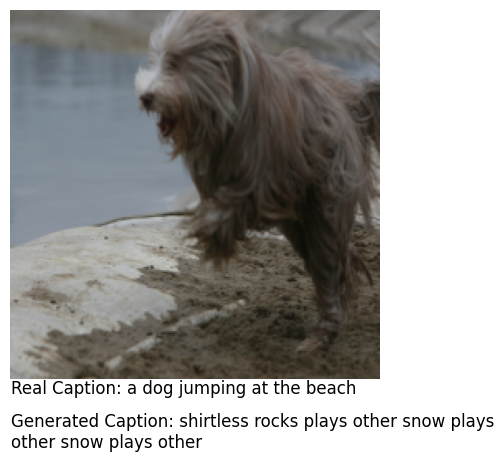

In [127]:
display_image_with_captions(image, real_caption[0], generated_caption)

In [132]:
text2speech(generated_caption)

100%|██████████| 63.6M/63.6M [00:02<00:00, 23.2MB/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:00<00:00, 224MB/s]  
Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth
100%|██████████| 16.7M/16.7M [00:00<00:00, 132MB/s] 
